In [283]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib as mpl
cmp = mpl.cm.viridis
from astropy.cosmology import FlatLambdaCDM
from matplotlib.colors import LogNorm

cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.27, Ob0 = 0.046)

In [284]:
results = {}

keys = ['m_all', 'at_rh', 'at_10rh','at_20kpc', 'rh', 'DD', 'redshift']

for hh, halo in enumerate(['8508', '4123', '5016', '2392', '2878','5036']):
    DD_z = np.load('/Users/rsimons/Dropbox/foggie/catalogs/DD_redshift.npy', allow_pickle = True)[()]
    results[halo] = {}
    for mtype in ['young_stars', 'stars', 'cold']:
        results[halo][mtype] = {}
        for key in keys:
            results[halo][mtype][key] = []
        profdir = '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/rprof'%halo
        all_rprof_fname = profdir + '/' + 'all_rprof_%s.npy'%halo
        all_rprof = np.load(all_rprof_fname, allow_pickle = True)[()]

        DDs = list(all_rprof.keys())
        
        for DD in DDs:           
            #calculate rstars half
            rprof = all_rprof[DD]['stars']['rprof']
            r = rprof['r']
            m  = rprof['mass']
            use = where(r < 30)[0]
            m_csum = np.cumsum(m[use])
            m_csum/=m_csum[-1]
            r_half = np.interp(0.5, m_csum, r[use])
            
            
            rprof = all_rprof[DD][mtype]['rprof']
            r = rprof['r']
            m  = rprof['mass']
            use = where(r < 30)[0]
            Lx = cumsum(rprof['Lx'][use])*u.cm**2*u.g/u.s
            Ly = cumsum(rprof['Ly'][use])*u.cm**2*u.g/u.s
            Lz = cumsum(rprof['Lz'][use])*u.cm**2*u.g/u.s
            m  = cumsum(rprof['mass'][use])*u.Msun
            j = np.sqrt(Lx**2 + Ly**2 + Lz**2)/m
            j = j.to('kpc*km/s').value

            j_rh   = np.interp(r_half, r[use], j)
            j_10rh = np.interp(10*r_half, r[use], j)
            j_20kpc = np.interp(20, r[use], j)
            redshift = float(DD_z[halo]['DD%.4i'%int(DD)])

            results[halo][mtype]['DD'].append(DD)
            results[halo][mtype]['redshift'].append(redshift)
            results[halo][mtype]['m_all'].append(log10(m[-1].value))
            results[halo][mtype]['at_rh'].append(log10(j_rh))
            results[halo][mtype]['at_10rh'].append(log10(j_10rh))
            results[halo][mtype]['at_20kpc'].append(log10(j_20kpc))
            results[halo][mtype]['rh'].append(r_half)
        for key in keys:            
            results[halo][mtype][key] = np.array(results[halo][mtype][key])

np.save('/Users/rsimons/Dropbox/foggie/catalogs/j_mstar.npy', results)

/Users/rsimons/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-284-cd7f6f8a6a07>:47: RuntimeWarning: divide by zero encountered in log10
  results[halo][mtype]['m_all'].append(log10(m[-1].value))
/Users/rsimons/.local/lib/python3.8/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(


KeyboardInterrupt: 

# Compare RF 12

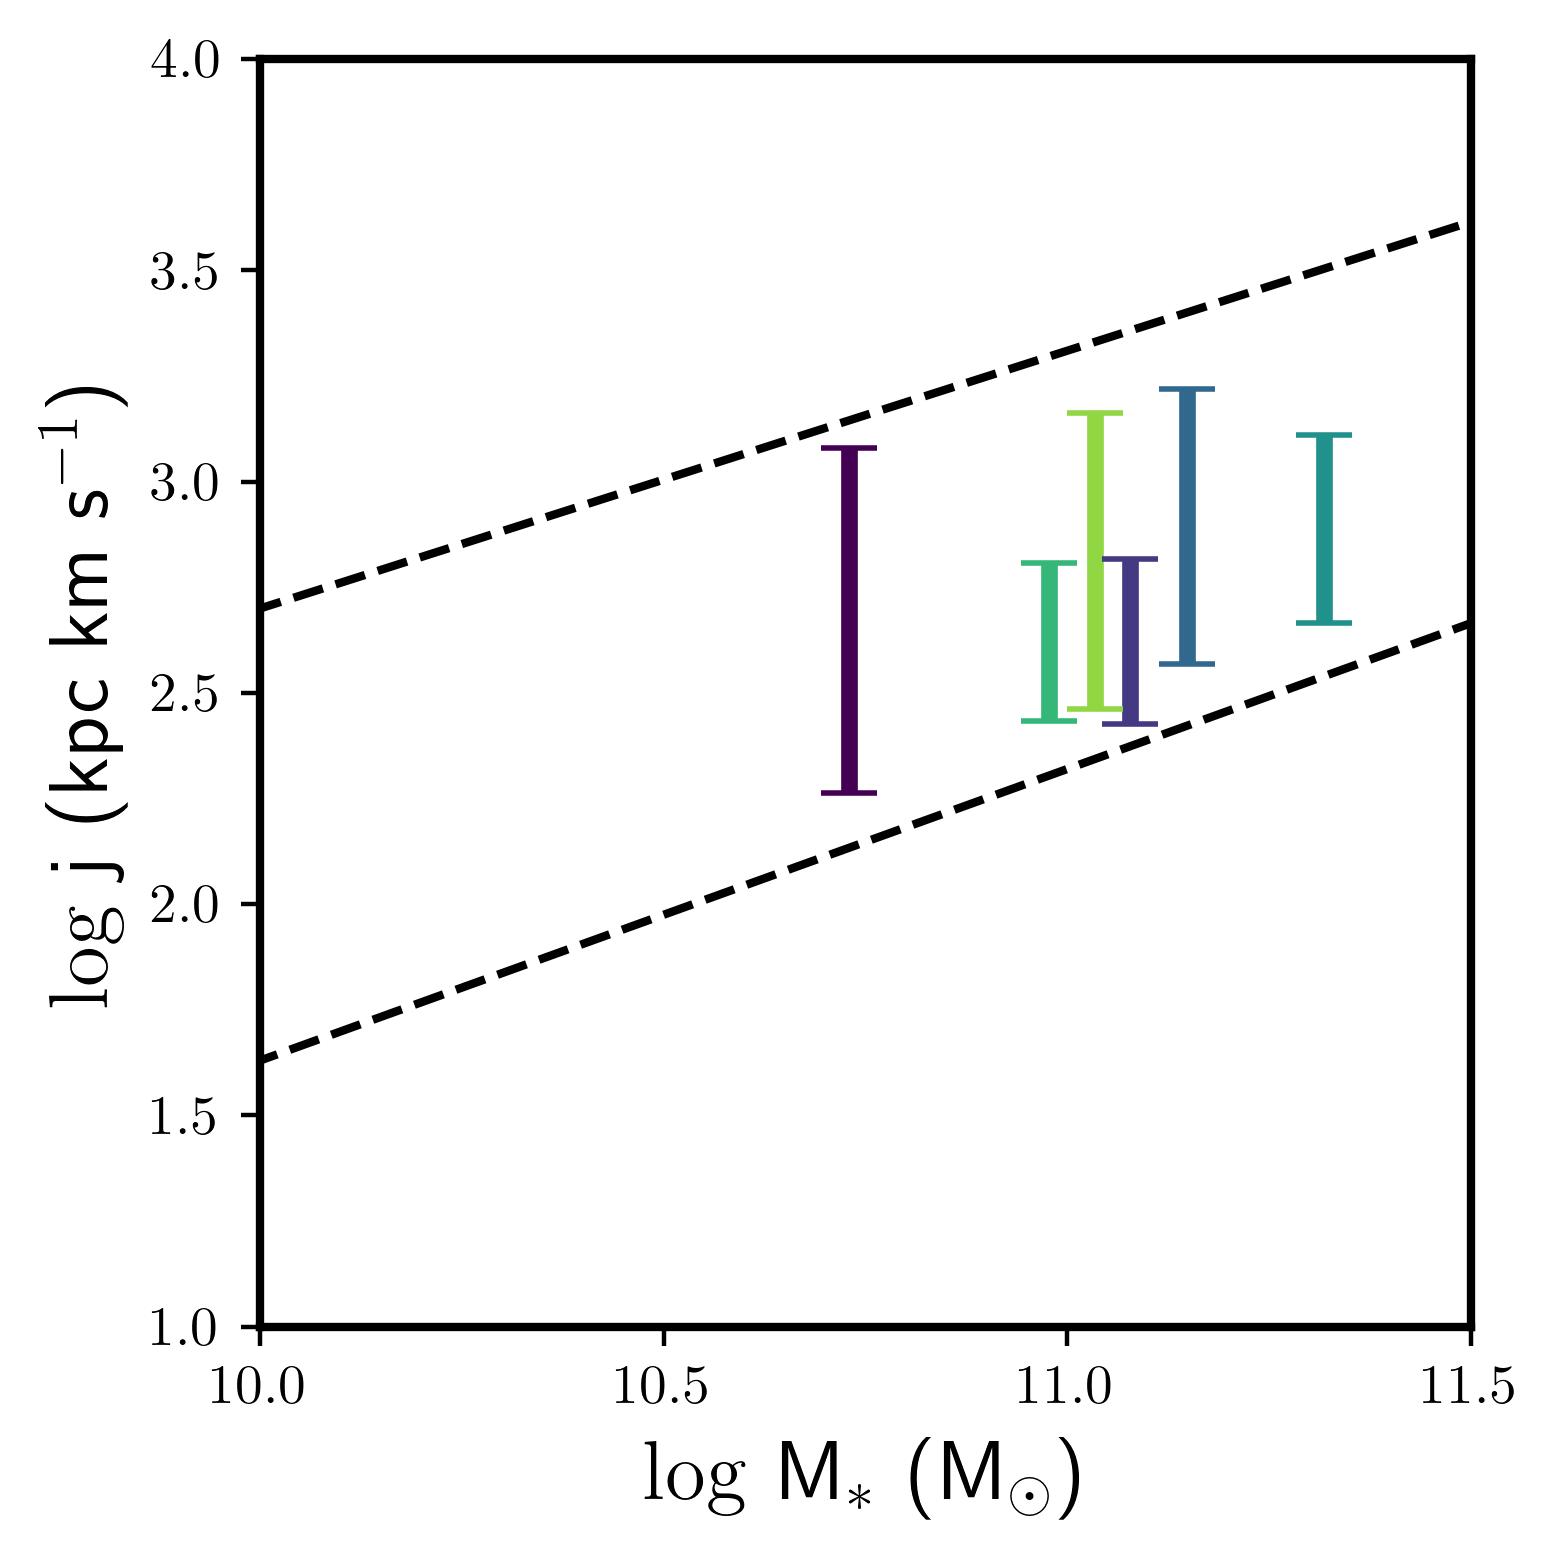

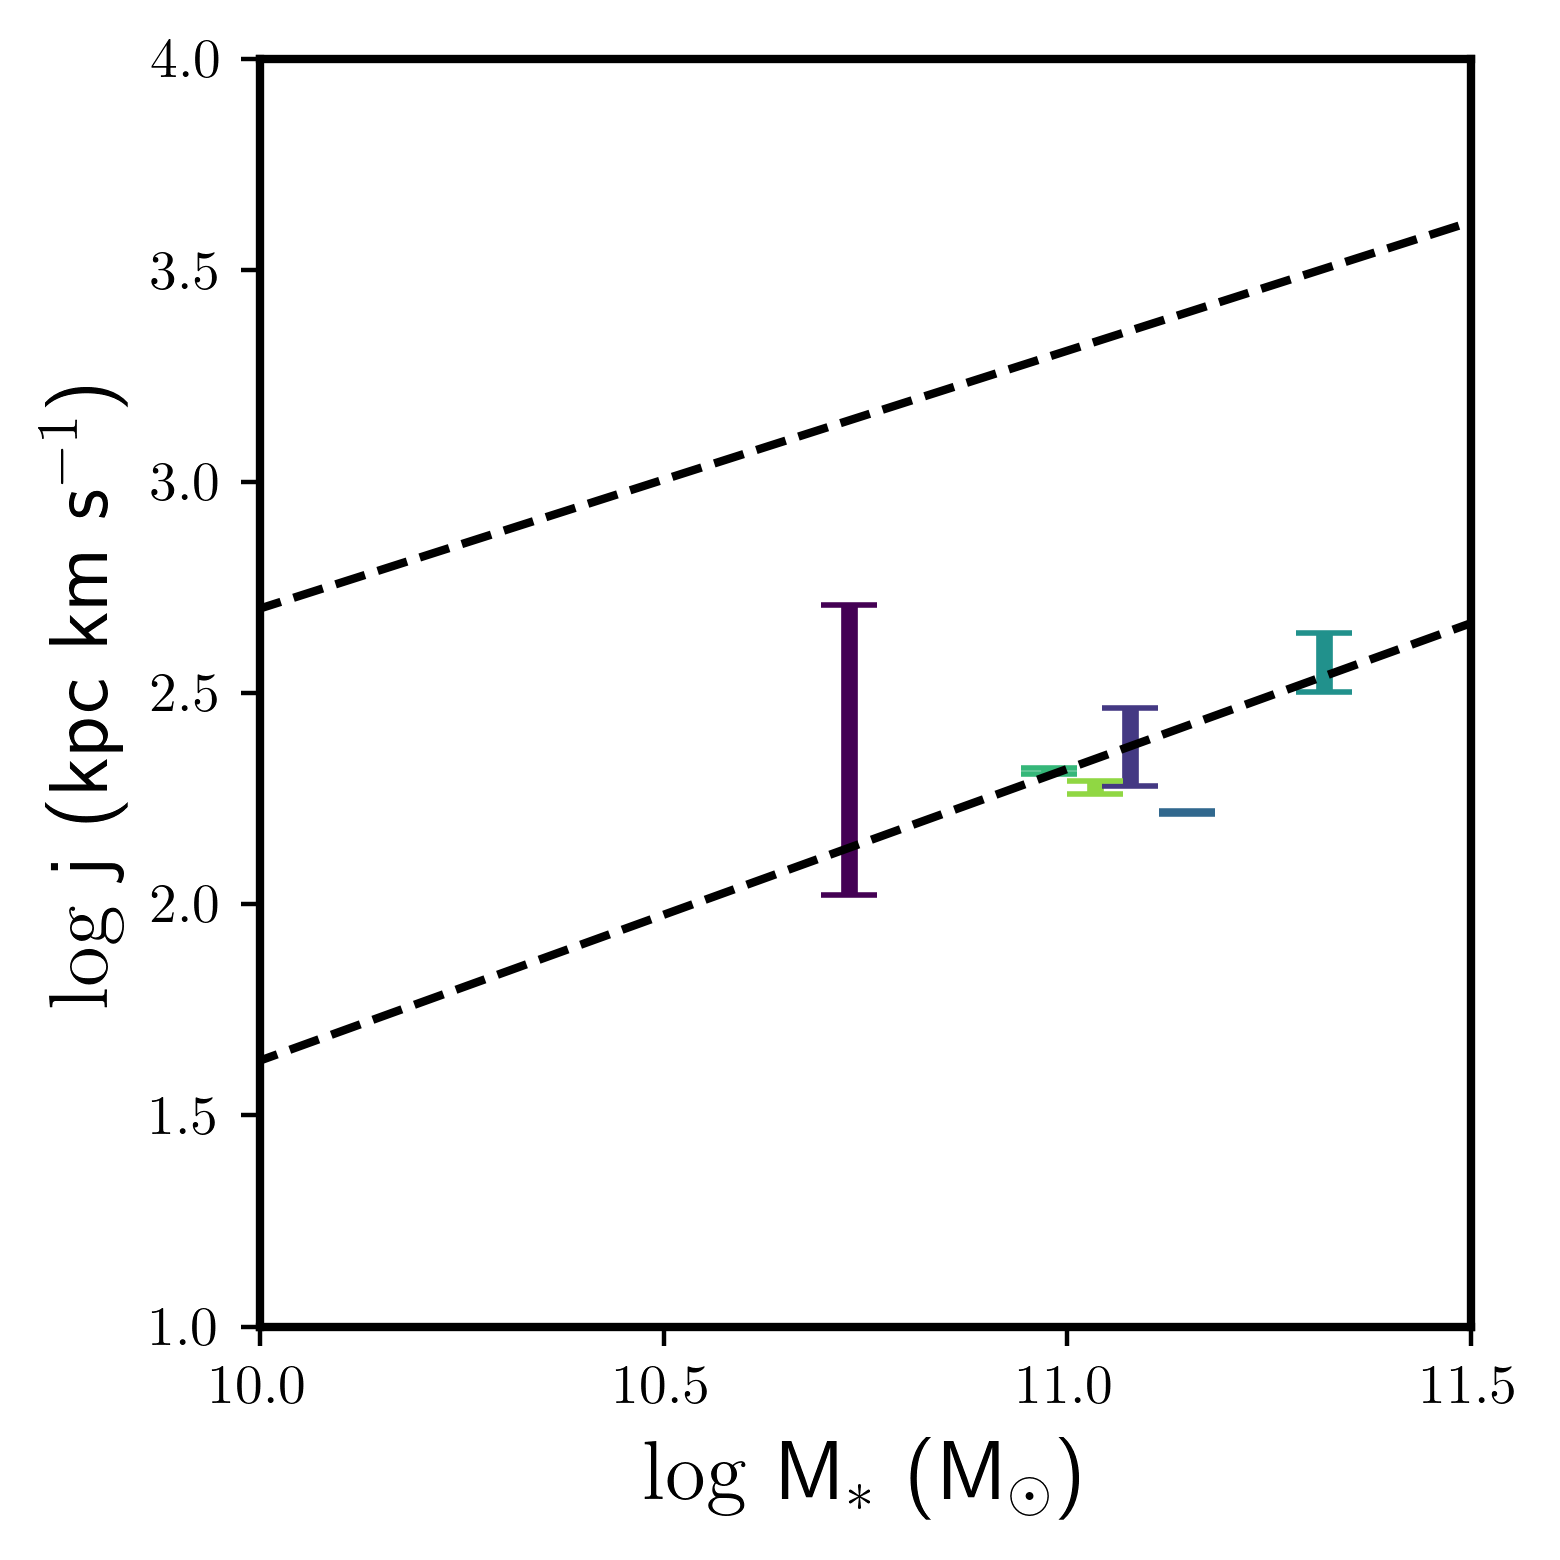

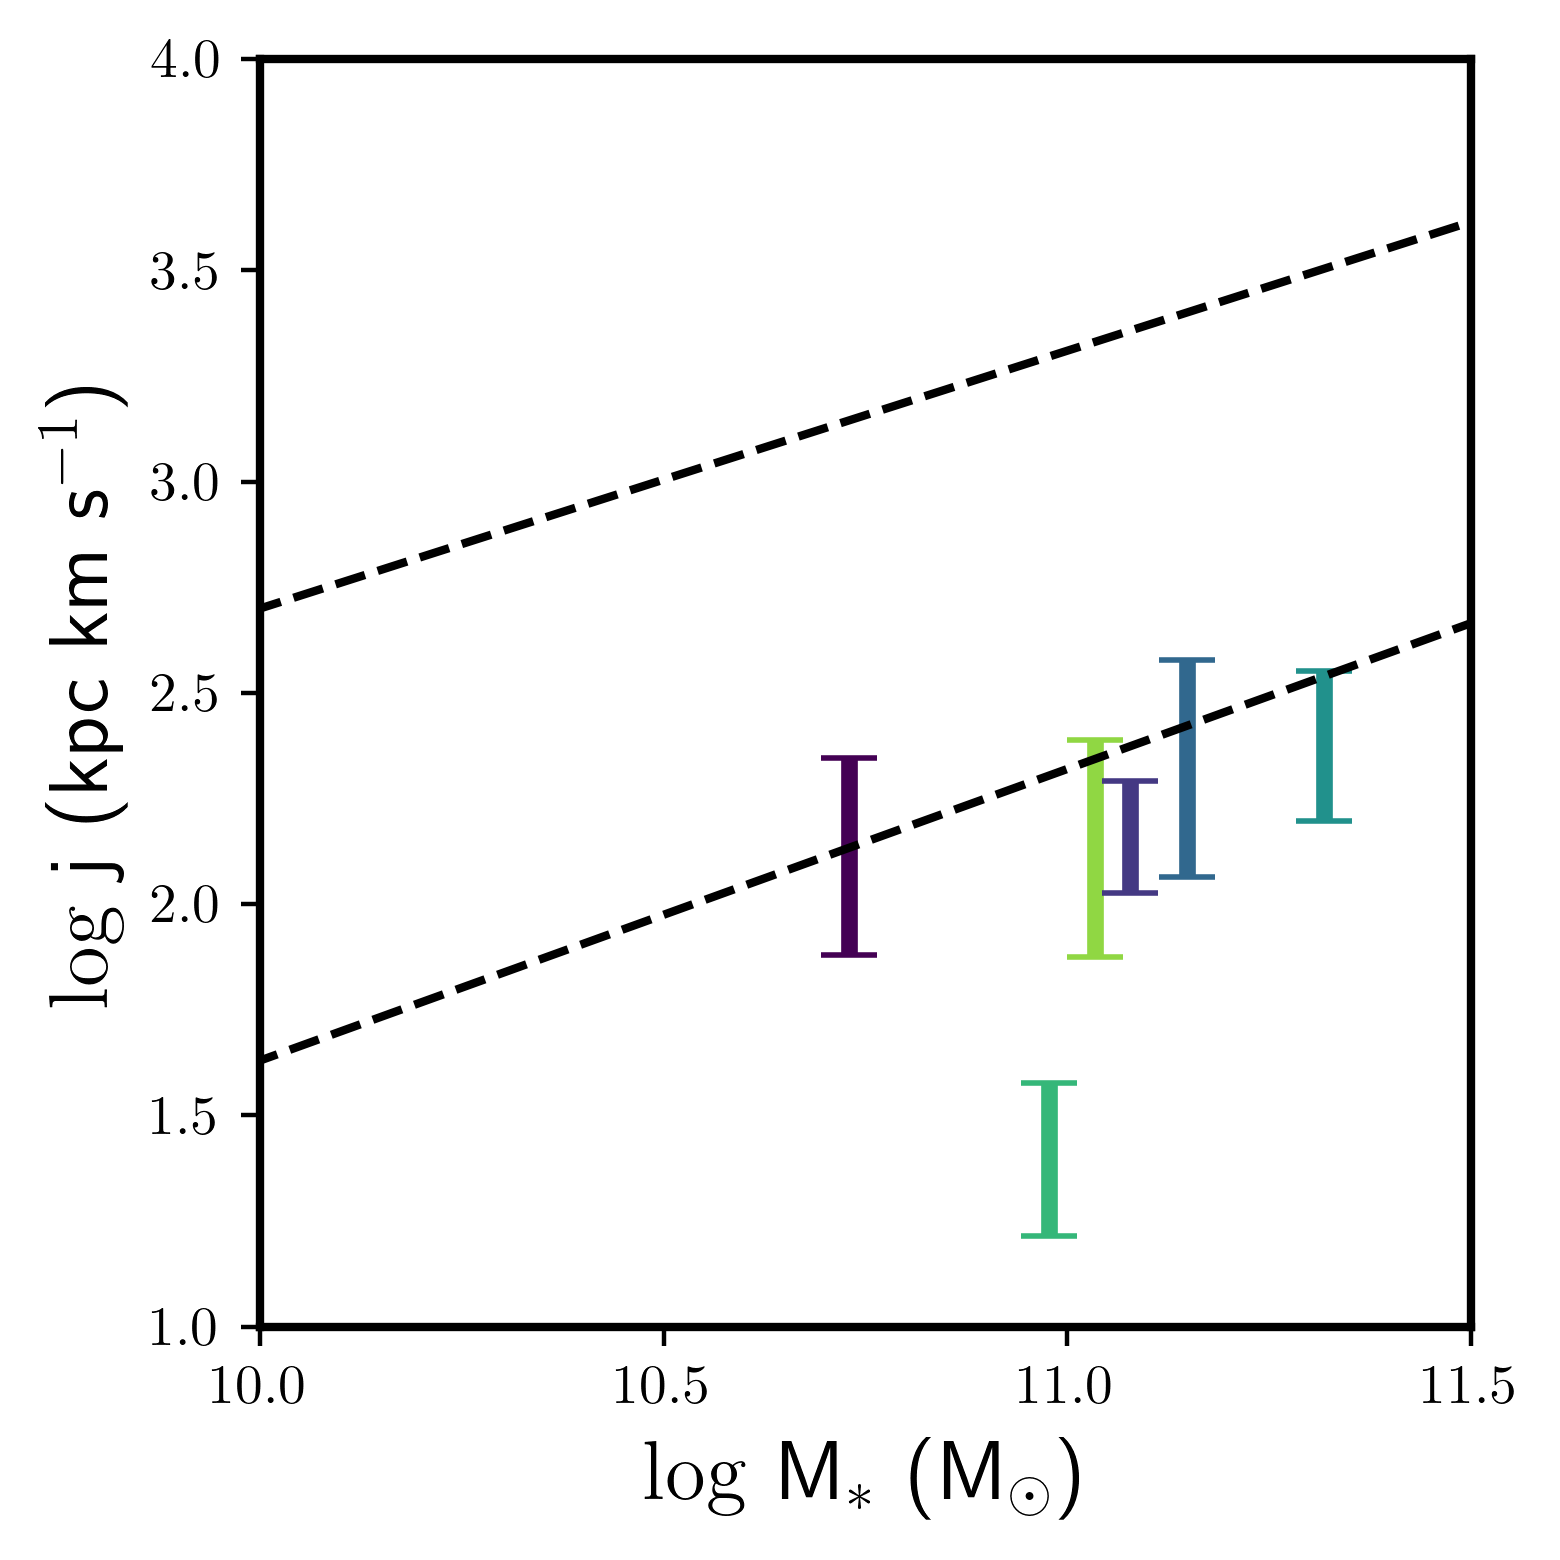

In [294]:
results = np.load('/Users/rsimons/Dropbox/foggie/catalogs/j_mstar.npy', allow_pickle = True)[()]
for mm, mtype in enumerate(['cold','young_stars', 'stars']):
    fig, ax = plt.subplots(1,1, figsize = (4,4), facecolor = 'white')
    for hh, halo in enumerate(['8508',  '5016', '4123', '2392', '2878', '5036']):
        gd      = results[halo]['stars']['redshift'] < 2.0
        m_all   = results[halo]['stars']['m_all'][gd]
        at_rh   = results[halo][mtype]['at_rh'][gd]
        at_10rh = results[halo][mtype]['at_10rh'][gd]
        srt = argsort(m_all)            
        #if (halo == '5036') | (halo == '8508') | (halo == '4123') | (halo == '2878') | (halo == '5016') | (halo == '2392'): 
        if False:
        #if (halo == '5036'): 

            ax.fill_between(m_all[srt], at_rh[srt], at_10rh[srt], 
                          color = cmp(hh/6.), alpha = 0.3,linewidth = 0)
            #ax.plot(m_all[srt], at_rh[srt], color = 'black', linewidth = 0.1)
            #ax.plot(m_all[srt], at_10rh[srt], color = 'black', linewidth = 0.1)

        ymd = (at_rh[-1] + at_10rh[-1])/2.
        uye = at_10rh[-1] - (at_rh[-1] + at_10rh[-1])/2.
        lye = (at_rh[-1] + at_10rh[-1])/2. - at_rh[-1]
        ax.errorbar(m_all[-1], ymd, 
                    yerr = [[uye], [lye]], capsize = 5, 
                     fmt = 'o', markersize = 0, linewidth = 3, color = cmp(hh/6.))
        ax.set_xticks(np.arange(10, 12, 0.5))
    xuse = np.linspace(9, 12, 10)
    rf_disk = 0.61*(xuse - 11) + 3.31
    rf_bulge = 0.69*(xuse - 11) + 2.32

    ax.plot(xuse, rf_disk, 'k--')
    ax.plot(xuse, rf_bulge, 'k--')

    ax.set_ylim(1, 4)
    ax.set_xlim(10, 11.5)
    ax.set_xlabel('$\log$ M$_*$ (M$_{\odot}$)')
    ax.set_ylabel('$\log $ j (kpc km s$^{-1}$)')


    fig.set_dpi(400)
    fig.tight_layout()
    fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/RF/%s_RF.png'%(mtype))

In [101]:
m_mhal = 0.007
correct_factor_z2 = {'5016': 0.92/(m_mhal * 0.16 * 100), 
                     '8508': 1.56/(m_mhal * 0.14 * 100),
                     '4123': 4.89/(m_mhal * 0.48 * 100),
                     '2392': 2.75/(m_mhal * 0.52 * 100),
                     '2878': 3.21/(m_mhal * 0.73 * 100),
                     '5036': 3.25/(m_mhal * 0.33 * 100)}

14.069264069264069


# Compare Burkert

<ipython-input-117-e9dbe5c31ee4>:44: RuntimeWarning: divide by zero encountered in log10
  m_all   = log10(10**results[halo]['stars']['m_all']/correct_fac)


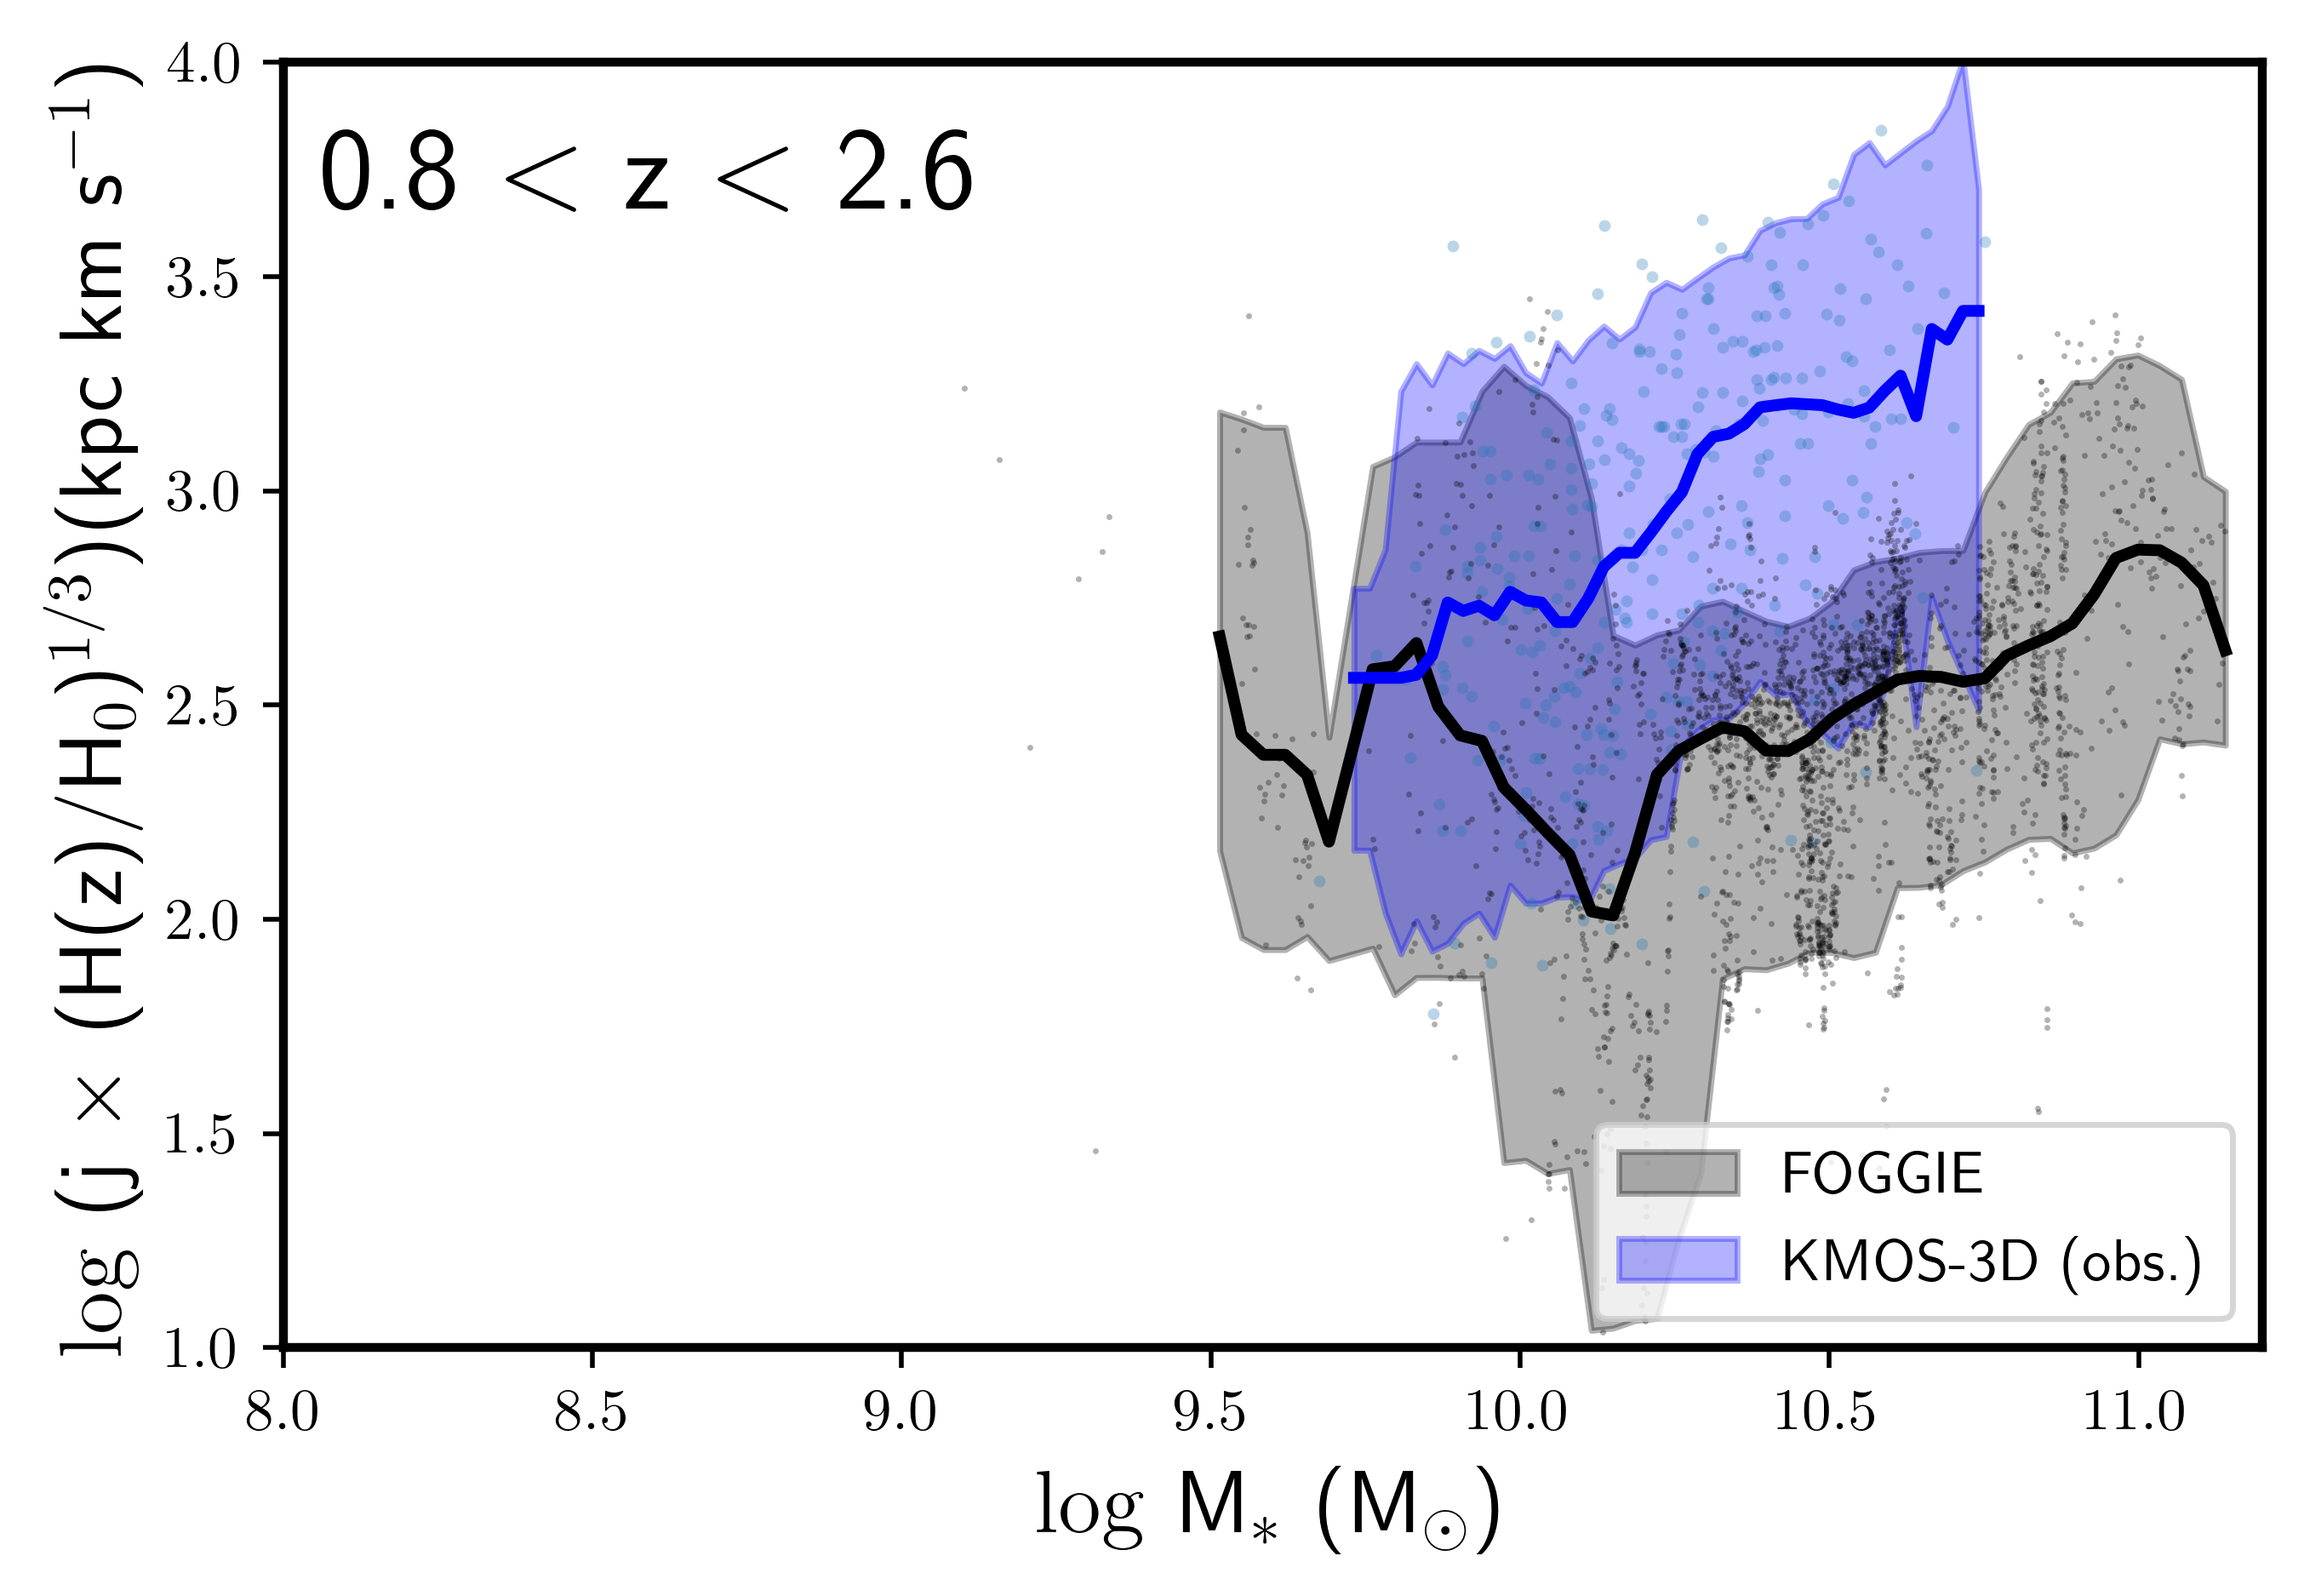

In [117]:
burkert = np.loadtxt('/Users/rsimons/Dropbox/foggie/catalogs/burkert_16.cat')
results = np.load('/Users/rsimons/Dropbox/foggie/catalogs/j_mstar.npy', allow_pickle = True)[()]


#taken from Table 1 of Simons+ 19
#0.007, average M*/Mhalo from Behroozi
m_mhal = 0.007
correct_factor_z2 = {'5016': 0.92/(0.16 * 100)/(0.002), 
                     '8508': 1.56/(0.14 * 100)/(0.002),
                     '5036': 3.25/(0.33 * 100)/(0.005),
                     '4123': 4.89/(0.48 * 100)/(0.008),
                     '2392': 2.75/(0.52 * 100)/(0.008),
                     '2878': 3.21/(0.73 * 100)/(0.010)}

use_correct = False



fig, ax = plt.subplots(1,1, figsize = (6,4), facecolor = 'white')

ax.plot(burkert[:,0], burkert[:,1], 'o', markersize = 2., alpha = 0.3, markeredgecolor = 'None')

for mm, mtype in enumerate(['cold','young_stars', 'stars'][1:2]):
    b = {}
    f = {}

    f['mid'] = []
    f['j16'] = []
    f['j50'] = []
    f['j84'] = []
    b['mid'] = []
    b['j16'] = []
    b['j50'] = []
    b['j84'] = []
    y_all = []
    x_all = []
    mm_all = []
    for hh, halo in enumerate(['8508',  '5016', '4123', '2392', '2878', '5036']):
        redshift = results[halo]['stars']['redshift'].astype('float')
        gd = where((redshift > 0.8) & (redshift < 2.6))[0]
        if use_correct: correct_fac = correct_factor_z2[halo]
        else: correct_fac = 1.

        m_all   = log10(10**results[halo]['stars']['m_all']/correct_fac)
        at_rh   = results[halo][mtype]['at_20kpc']
        Hz = np.array([cosmo.H(z)/cosmo.H0 for z in redshift[gd]])
        x = m_all[gd]
        y = np.log10(10**at_rh[gd] * Hz**(1/3.))
        for (xx, yy) in zip(x, y):
            x_all.append(xx)
            y_all.append(yy)
        ax.plot(x, y, 'o', color = 'black', markersize = 1., alpha = 0.3, markeredgecolor = 'None')
        #counts,xbins,ybins,image = histogram2d(x,y,bins=100, norm=LogNorm())
        #ax.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=1)
    y_all  = np.array(y_all)
    x_all  = np.array(x_all)
    mm_all = np.array(mm_all)
    percs = [5, 50, 95]
    for m1 in np.linspace(8, 11.5, 100):
        gd2 = where((x_all > m1) & (x_all < m1+0.2))[0]
        if len(gd2) < 30: continue
        p16, p50, p84 = np.percentile(y_all[gd2], percs)
        f['mid'].append((m1 + 0.1))
        f['j16'].append(p16)
        f['j50'].append(p50)
        f['j84'].append(p84)

    for m1 in np.linspace(9, 11.5, 100):
        gd2 = where((burkert[:,0] > m1) & (burkert[:,0] < m1+0.2))[0]
        if len(gd2) < 5: continue
        p16, p50, p84 = np.percentile(burkert[:,1][gd2], percs)
        b['mid'].append((m1 + 0.1))
        b['j16'].append(p16)
        b['j50'].append(p50)
        b['j84'].append(p84)
        
    ax.plot(f['mid'], f['j50'], 'k-', linewidth = 2)
    ax.plot(b['mid'], b['j50'], 'b-', linewidth = 2)
    #ax.plot(f['mid'], f['j16'], 'k--')
    #ax.plot(f['mid'], f['j84'], 'k--')
    ax.fill_between(np.array(f['mid']), f['j16'], f['j84'], color = 'black', alpha = 0.3, label = 'FOGGIE')
    ax.fill_between(np.array(b['mid']), b['j16'], b['j84'], color = 'blue', alpha = 0.3, label = 'KMOS-3D (obs.)')
ax.set_xticks(np.arange(7.0, 11.5, 0.5))
ax.legend(loc = 4)
ax.set_ylim(1.0, 4.0)

#if use_correct:ax.set_xlim(8.0, 11.2)
#else: ax.set_xlim(9.5, 11.2)
ax.set_xlim(8, 11.2)
ax.set_xlabel('$\log$ M$_*$ (M$_{\odot}$)')
ax.set_ylabel('$\log $ (j '+r'$\times$ (H(z)/H$_0$)$^{1/3}$)'+'(kpc km s$^{-1}$)')
ax.annotate('0.8 $<$ z $<$ 2.6', (0.02, 0.95), xycoords = 'axes fraction', ha = 'left', va = 'top',
            fontsize = 20, fontweight = 'bold', color = 'black')
if use_correct: figname = 'burkert16_wcorrection.png'
else: figname = 'burkert16.png'
fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/%s'%figname, dpi = 500)
fig.set_dpi(500)


In [106]:
m_all

array([0.67468214, 0.67519135, 0.67581213, ..., 0.78429157, 0.78429584,
       0.78429686])

In [180]:
from astropy.cosmology import Planck15 as cosmo

<Quantity 3.00633>

In [223]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.27, Ob0 = 0.046)
cosmo.H(2)/cosmo.H0

<Quantity 2.83196045>